In [1]:
import cartopy.crs as ccrs
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import xarray as xr
import plot_tools as pt
import xgcm

In [2]:
clnt = dsk.Client()
clnt

<Client: 'tcp://127.0.0.1:36673' processes=4 threads=16, memory=68.72 GB>

In [23]:
def change_lon_space(ds):
    ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
    ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
    ds = ds.swap_dims({'lon': '_lon_adj'})
    ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
    ds = ds.rename({'_lon_adj': 'lon'})
    return ds

def extract_so(ds):
    ds_so = ds.sel(lat = slice(None, -50))
    return ds_so

# Open and save data

In [4]:
uas_jra = xr.open_dataset('/home/561/jn8053/g_e14/project-1-v3/data/forcing/uas-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
vas_jra = xr.open_dataset('/home/561/jn8053/g_e14/project-1-v3/data/forcing/vas-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))

In [52]:
historical_dirs = glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/**/**/historical/r1i1p1f1/Amon/uas/*/*/')
del historical_dirs[-10]
del historical_dirs[-9]
del historical_dirs[-1]

# Open vas from models as they are
uas_cmip = {}
for file_path in historical_dirs:
    model_name = file_path.split('/')[8]
    if model_name in ['CIESM', 'CMCC-CM2-SR5', 'CMCC-CM2-HR4', 'CMCC-ESM2', 'CAS-ESM2-0', 'CAMS-CSM1-0']:
        pass
    else:
        uas = xr.open_mfdataset(file_path+'*.nc', parallel = True, preprocess = extract_so).sel(time = slice('1958-01-01', '2015-01-01'))
        uas = uas.interp(lat = uas_jra['lat'], lon = uas_jra['lon'])
        uas_cmip[model_name] = uas

# Multimodel mean
models = list(uas_cmip.keys())
for i in range(len(models)):
    uas = uas_cmip[models[i]]['uas']
    uas.to_netcdf('../../data/tmp/uas_hist'+models[i]+'.nc')
# Then cdo ensmean tmp/* psl_cmip6_historical_mmm.nc

In [55]:
historical_dirs = glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/**/**/historical/r1i1p1f1/Amon/vas/*/*/')
del historical_dirs[-10]
del historical_dirs[-9]
del historical_dirs[-1]

# Open vas from models as they are
vas_cmip = {}
for file_path in historical_dirs:
    model_name = file_path.split('/')[8]
    if file_path in skip:
        pass
    elif model_name in ['CIESM', 'CMCC-CM2-SR5', 'CMCC-CM2-HR4', 'CMCC-ESM2', 'CAS-ESM2-0', 'CAMS-CSM1-0']:
        pass
    else:
        vas = xr.open_mfdataset(file_path+'*.nc', parallel = True, preprocess = extract_so).sel(time = slice('1958-01-01', '2015-01-01'))
        vas = vas.interp(lat = vas_jra['lat'], lon = vas_jra['lon'])
        vas_cmip[model_name] = vas

# Multimodel mean
models = list(vas_cmip.keys())
for i in range(len(models)):
    vas = vas_cmip[models[i]]['vas']
    vas.to_netcdf('../../data/tmp/vas_hist'+models[i]+'.nc')
# Then cdo ensmean tmp/vas* vas_cmip6_historical_mmm.nc

### SSP for Paul

In [13]:
historical_dirs_psl = glob.glob('/g/data/oi10/replicas/CMIP6/CMIP/**/**/historical/r1i1p1f1/Amon/psl/*/*/')

skip = ['/g/data/oi10/replicas/CMIP6/CMIP/E3SM-Project/E3SM-1-0/historical/r1i1p1f1/Amon/psl/gr/v20190730/',
        '/g/data/oi10/replicas/CMIP6/CMIP/E3SM-Project/E3SM-1-1-ECA/historical/r1i1p1f1/Amon/psl/gr/v20200127/',
        '/g/data/oi10/replicas/CMIP6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/Amon/psl/gn/v20200218/',
        '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorCPM1/historical/r1i1p1f1/Amon/psl/gn/v20190914/',
        '/g/data/oi10/replicas/CMIP6/CMIP/UA/MCM-UA-1-0/historical/r1i1p1f1/Amon/psl/gn/v20190731/']

# Open vas from models as they are
psl_cmip = {}
for file_path in historical_dirs_psl:
    model_name = file_path.split('/')[8]
    if file_path in skip:
        pass
    elif model_name in ['CIESM', 'CMCC-CM2-SR5', 'CMCC-CM2-HR4', 'CMCC-ESM2', 'CAS-ESM2-0', 'CAMS-CSM1-0']:
        pass
    else:
        psl = xr.open_mfdataset(file_path+'*.nc', parallel = True, preprocess = extract_so).sel(time = slice('1958-01-01', '2015-01-01'))
        psl = psl.interp(lat = uas_jra['lat'], lon = uas_jra['lon'])
        psl_cmip[model_name] = psl

# Multimodel mean
models = list(psl_cmip.keys())
for i in range(len(models)):
    psl = psl_cmip[models[i]]['psl']
    psl.to_netcdf('../../data/tmp/psl_hist'+models[i]+'.nc')
# Then cdo ensmean tmp/* psl_cmip6_historical_mmm.nc

In [41]:
psl_cmip6 = xr.open_dataset('../../data/psl_cmip6_historical_mmm.nc')

# Historical UAS

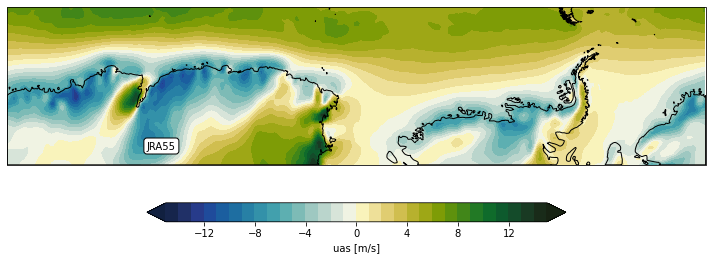

In [56]:
fig, axs = pt.circumpolar_map()
cf = axs.contourf(uas_jra['lon'], uas_jra['lat'], uas_jra['uas'].mean('time'),
                  levels = np.arange(-15, 16, 1), cmap = cmocean.cm.delta, extend = 'both', transform = ccrs.PlateCarree())
axs.text(0.2, 0.1, 'JRA55', transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
cbar = fig.colorbar(cf, ax = axs, orientation = 'horizontal', shrink = .6)
cbar.set_label('uas [m/s]')
plt.tight_layout()
plt.savefig('../../results/easterlies/historical/uas_mean_jra55.png', facecolor = 'white', bbox_inches = 'tight')

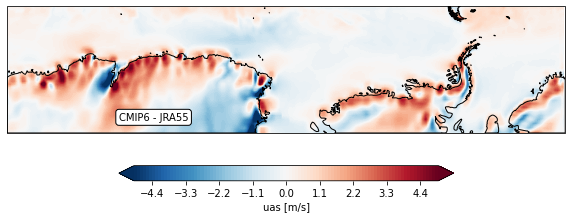

In [18]:
fig, axs = pt.circumpolar_map()
cf = axs.contourf(uas_jra['lon'], uas_jra['lat'], uas_cmip6_hist_mean.mean('model') - uas_jra['uas'].mean('time'),
                  levels = np.arange(-5, 5.1, .1), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
axs.text(0.2, 0.1, 'CMIP6 - JRA55', transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
cbar = fig.colorbar(cf, ax = axs, orientation = 'horizontal', shrink = .6)
cbar.set_label('uas [m/s]')
plt.savefig('../../results/easterlies/historical/uas_mean_cmip6-jra55.png', facecolor = 'white', bbox_inches = 'tight')

In [ ]:
for i in range(0, len(uas_cmip6_hist_mean['model'])):
    fig, axs = pt.circumpolar_map()
    cf = axs.contourf(uas_jra['lon'], uas_jra['lat'], 
                      uas_cmip6_hist_mean.isel(model = i) - uas_jra['uas'].mean(dim = 'time'),
                      levels = np.arange(-5, 5.5, .5), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
    axs.text(0.2, 0.1, uas_cmip6_hist_mean['model'][i].item(), transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
    cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical', shrink = .6)
    cbar.set_label('uas [m/s]')
    plt.savefig('../../results/easterlies/historical/uas_mean_'+uas_cmip6_hist_mean['model'][i].item()+'-jra55.png', facecolor = 'white', bbox_inches = 'tight')

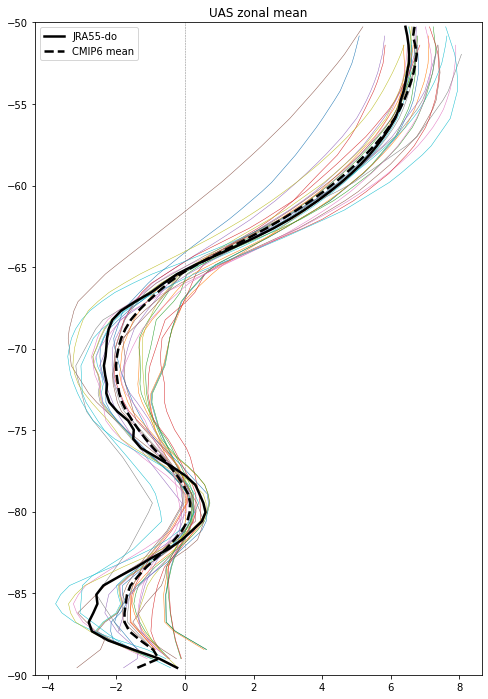

In [22]:
fig, axs = plt.subplots(figsize = (8, 12))
axs.axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
for i in range(0, len(uas_cmip6_hist_mean['model'])):
    axs.plot(uas_cmip6_hist_mean.isel(model = i).mean('lon'), uas_cmip6_hist_mean['lat'], linewidth = 0.5)    
axs.set_ylim(-90, -50)
uas_jra_z = uas_jra['uas'].mean('time').mean('lon')
axs.plot(uas_jra_z, uas_jra_z['lat'], color = 'k', linewidth = 2.5, label = 'JRA55-do')
axs.plot(uas_cmip6_hist_mean.mean(['model', 'lon']), uas_cmip6_hist_mean['lat'], color = 'k', linewidth = 2.5, linestyle = '--', label = 'CMIP6 mean')
plt.title('UAS zonal mean')
plt.legend()
plt.savefig('../../results/easterlies/historical/uas_zonal_mean.png', facecolor = 'white', bbox_inches = 'tight')

# Historical VAS

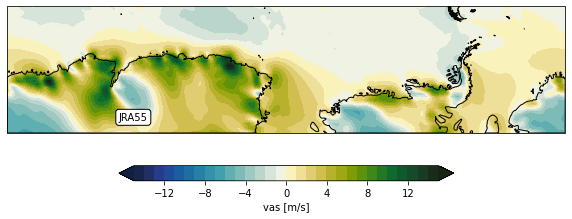

In [31]:
fig, axs = pt.circumpolar_map()
cf = axs.contourf(vas_jra['lon'], vas_jra['lat'], vas_jra['vas'].mean('time'),
                  levels = np.arange(-15, 16, 1), cmap = cmocean.cm.delta, extend = 'both', transform = ccrs.PlateCarree())
axs.text(0.2, 0.1, 'JRA55', transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
cbar = fig.colorbar(cf, ax = axs, orientation = 'horizontal', shrink = .6)
cbar.set_label('vas [m/s]')
plt.savefig('../../results/easterlies/historical/vas_mean_jra.png', facecolor = 'white', bbox_inches = 'tight')

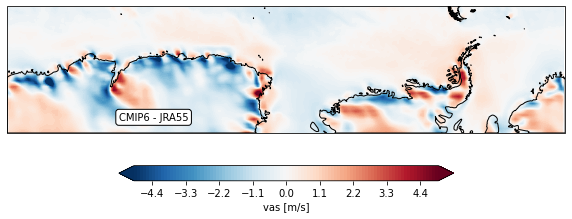

In [32]:
fig, axs = pt.circumpolar_map()
cf = axs.contourf(vas_jra['lon'], vas_jra['lat'], vas_cmip6_hist_mean.mean('model') - vas_jra['vas'].mean('time'),
                  levels = np.arange(-5, 5.1, .1), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
axs.text(0.2, 0.1, 'CMIP6 - JRA55', transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
cbar = fig.colorbar(cf, ax = axs, orientation = 'horizontal', shrink = .6)
cbar.set_label('vas [m/s]')
plt.savefig('../../results/easterlies/historical/vas_mean_cmip6-jra55.png', facecolor = 'white', bbox_inches = 'tight')

/g/data/e14/jn8053/project-2-v0/src/easterlies/plot_tools.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (10, 4))


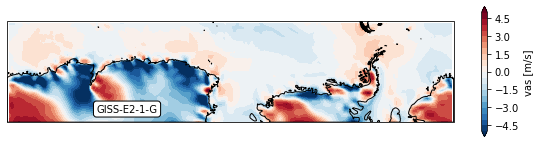

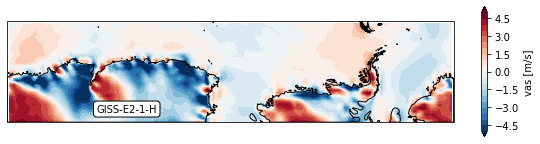

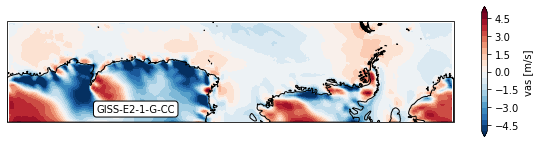

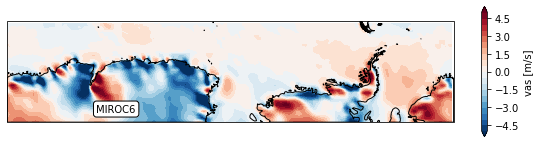

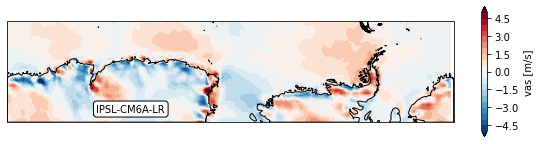

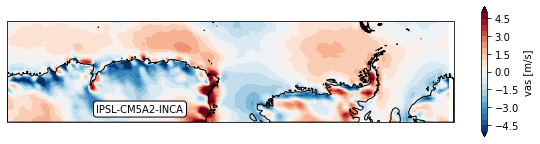

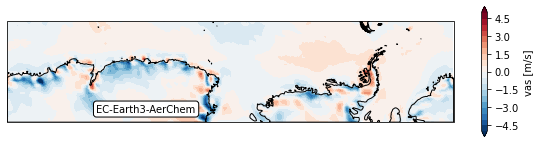

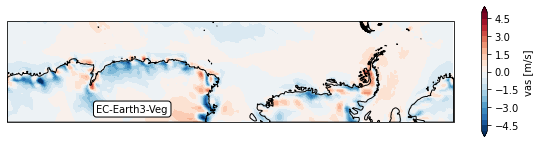

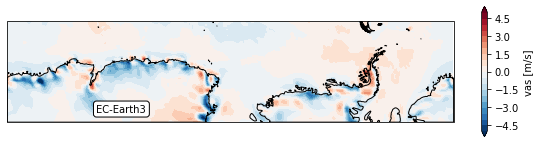

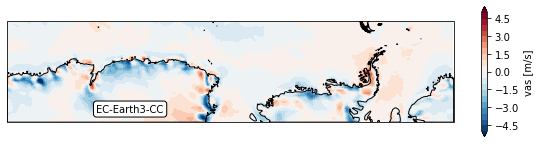

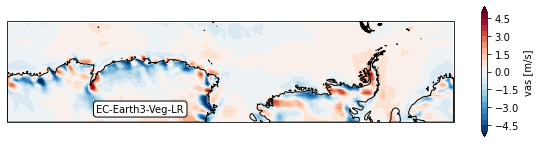

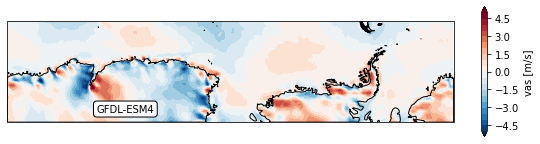

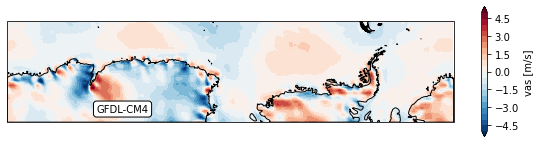

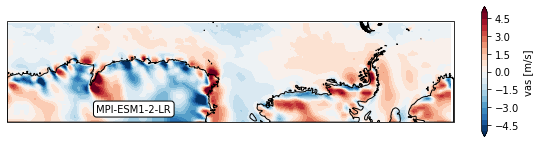

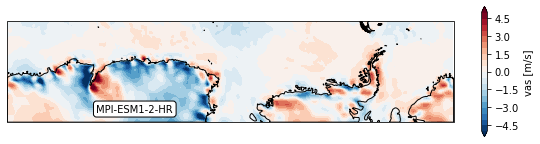

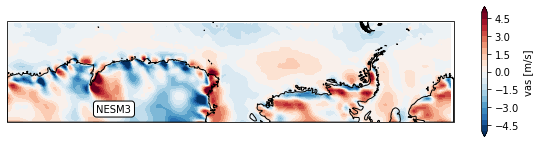

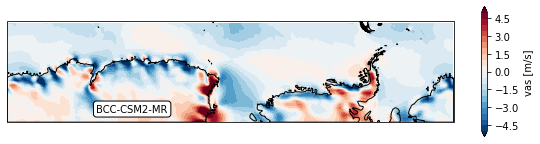

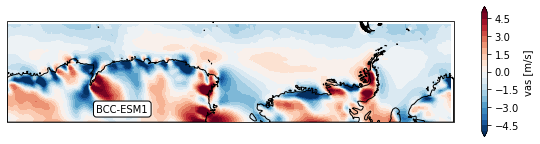

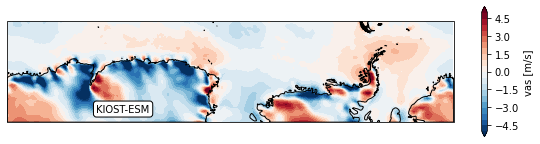

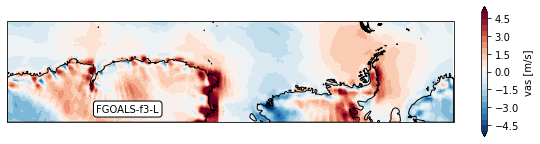

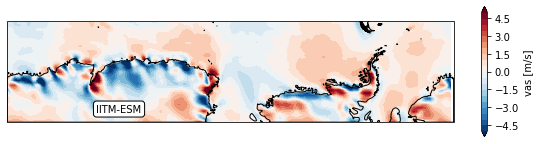

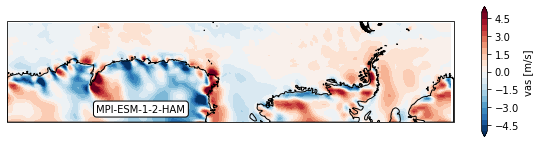

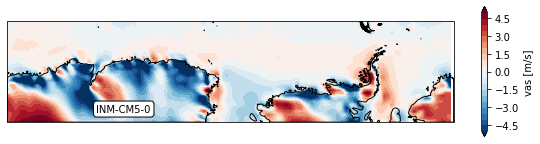

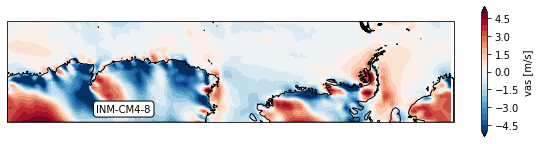

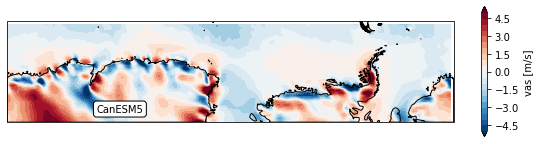

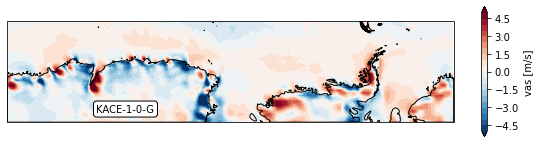

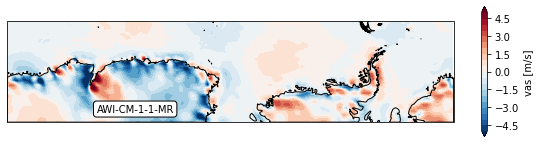

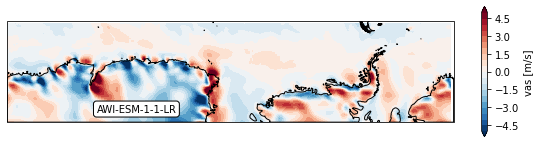

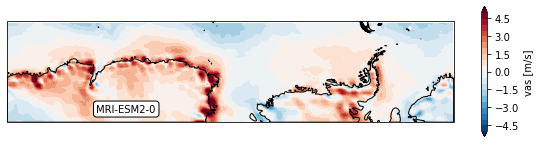

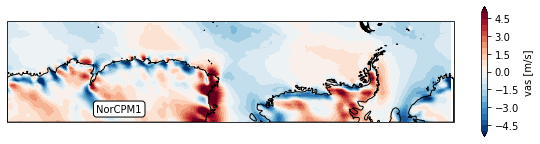

In [39]:
for i in range(0, len(vas_cmip6_hist_mean['model'])):
    fig, axs = pt.circumpolar_map()
    cf = axs.contourf(vas_jra['lon'], vas_jra['lat'], 
                      vas_cmip6_hist_mean.isel(model = i) - vas_jra['vas'].mean(dim = 'time'),
                      levels = np.arange(-5, 5.5, .5), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
    axs.text(0.2, 0.1, vas_cmip6_hist_mean['model'][i].item(), transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
    cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical', shrink = .6)
    cbar.set_label('vas [m/s]')
    plt.savefig('../../results/easterlies/historical/vas_mean_'+uas_cmip6_hist_mean['model'][i].item()+'-jra55.png', facecolor = 'white', bbox_inches = 'tight')

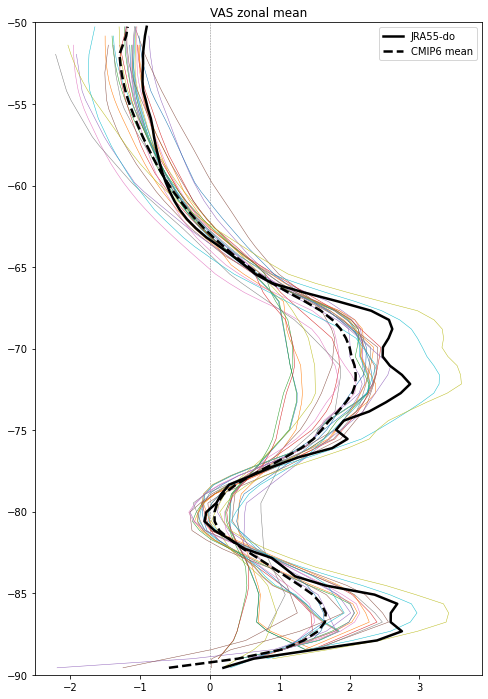

In [40]:
fig, axs = plt.subplots(figsize = (8, 12))
axs.axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
for i in range(0, len(vas_cmip6_hist_mean['model'])):
    axs.plot(vas_cmip6_hist_mean.isel(model = i).mean('lon'), vas_cmip6_hist_mean['lat'], linewidth = 0.5)    
axs.set_ylim(-90, -50)
vas_jra_z = vas_jra['vas'].mean('time').mean('lon')
axs.plot(vas_jra_z, vas_jra_z['lat'], color = 'k', linewidth = 2.5, label = 'JRA55-do')
axs.plot(vas_cmip6_hist_mean.mean(['model', 'lon']), vas_cmip6_hist_mean['lat'], color = 'k', linewidth = 2.5, linestyle = '--', label = 'CMIP6 mean')
plt.title('VAS zonal mean')
plt.legend()
plt.savefig('../../results/easterlies/historical/vas_zonal_mean.png', facecolor = 'white', bbox_inches = 'tight')

# SSP2-4.5

In [25]:
ssp45_dirs = glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/**/**/ssp245/r1i1p1f1/Amon/uas/*/*/')
del ssp45_dirs[-1]

uas_cmip_ssp45 = {}
for file_path in ssp45_dirs:
    model_name = file_path.split('/')[8]
    uas = xr.open_mfdataset(file_path+'*.nc', parallel = True, preprocess = extract_so).sel(time = slice('2015-01-01', '2101-01-01'))
    uas_cmip_ssp45[model_name] = uas

uas_ssp45 = uas_cmip_ssp45[ssp45_dirs[2].split('/')[8]]['uas'].interp(lat = uas_jra['lat'], lon = uas_jra['lon']).mean('time')
model_coord = [ssp45_dirs[2].split('/')[8]]
for i in range(3, len(ssp45_dirs)):
    if ssp45_dirs[i].split('/')[8] in ['CIESM', 'CMCC-CM2-SR5', 'CMCC-CM2-HR4', 'CMCC-ESM2', 'CAS-ESM2-0', 'CAMS-CSM1-0']:
        pass
    else:
        uas_ssp45 = xr.concat([uas_ssp45, uas_cmip_ssp45[ssp45_dirs[i].split('/')[8]]['uas'].interp(lat = uas_jra['lat'], lon = uas_jra['lon']).mean('time')], dim = 'model')
        model_coord.append(ssp45_dirs[i].split('/')[8])
uas_ssp45 = uas_ssp45.assign_coords({'model':model_coord})

In [26]:
list(uas_ssp45['model'].values)

['MIROC6',
 'NESM3',
 'IPSL-CM6A-LR',
 'BCC-CSM2-MR',
 'IITM-ESM',
 'MPI-ESM1-2-LR',
 'GFDL-CM4',
 'GFDL-ESM4',
 'FGOALS-f3-L',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'EC-Earth3',
 'EC-Earth3-CC',
 'INM-CM5-0',
 'INM-CM4-8',
 'KIOST-ESM',
 'MPI-ESM1-2-HR',
 'AWI-CM-1-1-MR',
 'MRI-ESM2-0',
 'KACE-1-0-G',
 'CanESM5']

/g/data/e14/jn8053/project-2-v0/src/easterlies/plot_tools.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (10, 4))


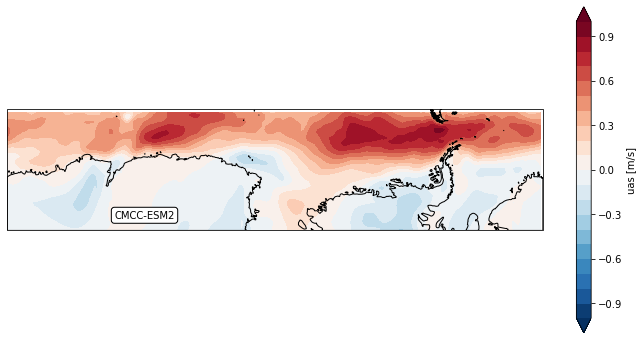

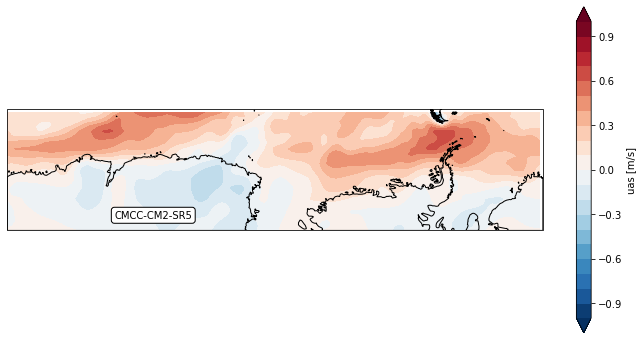

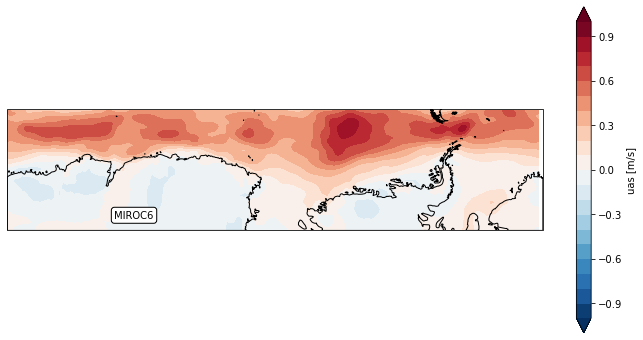

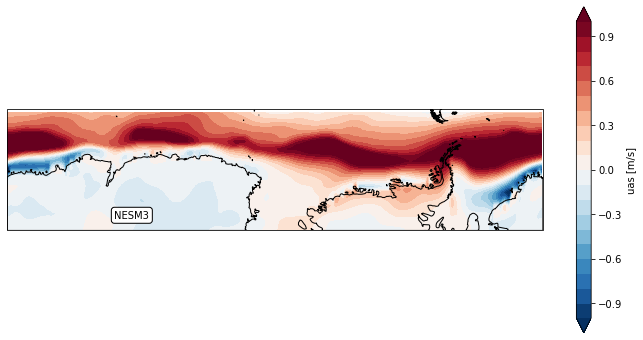

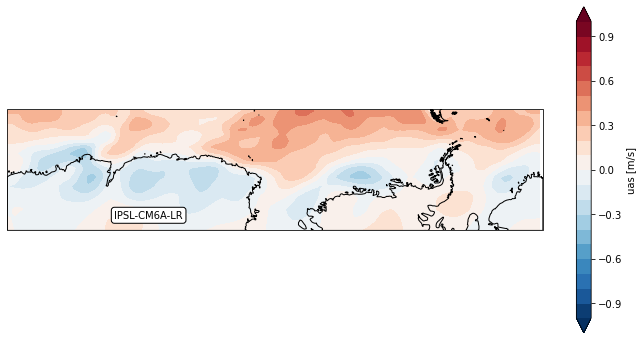

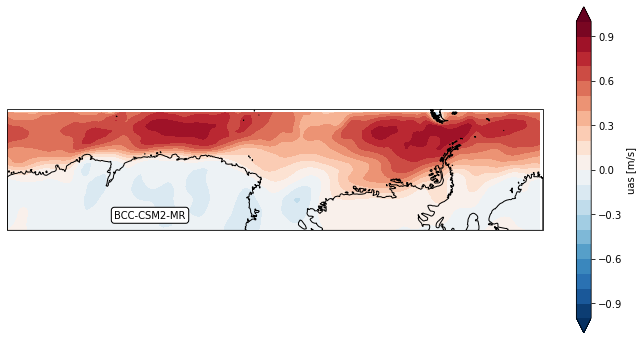

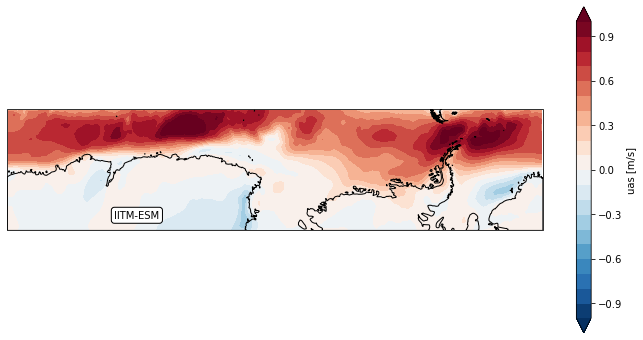

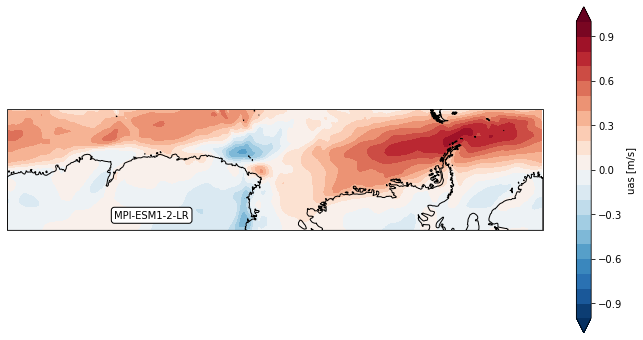

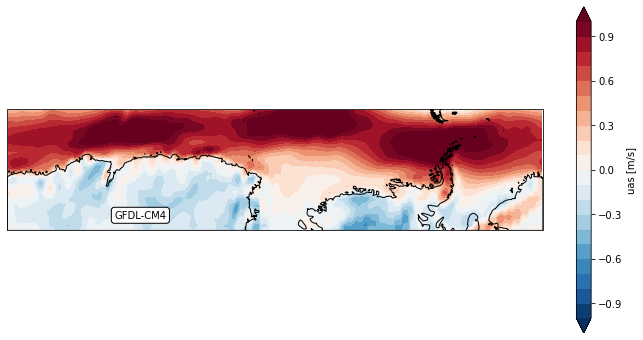

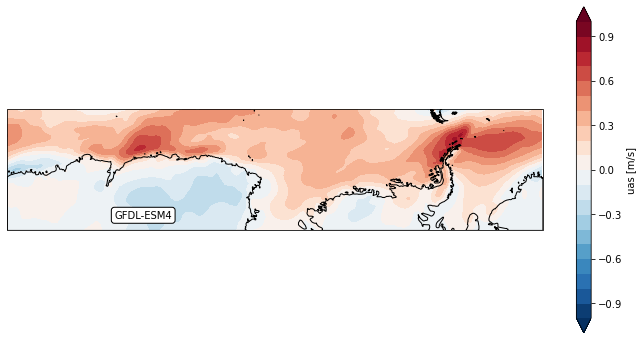

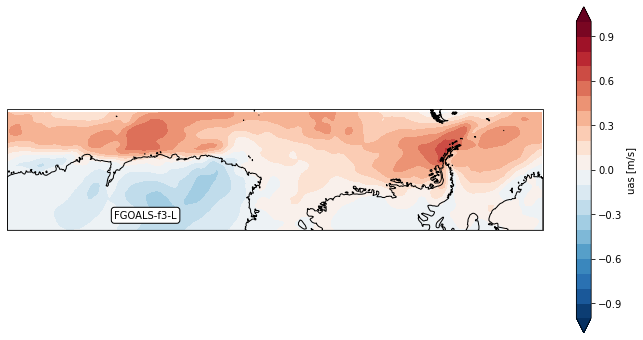

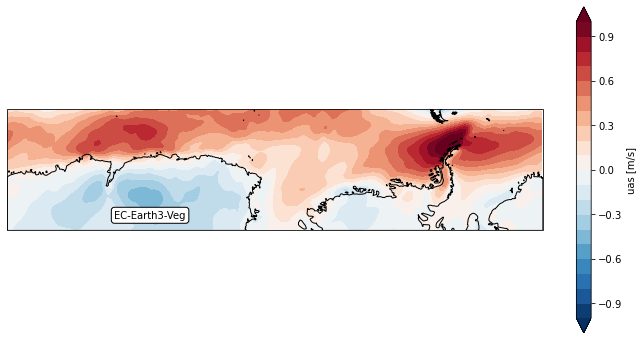

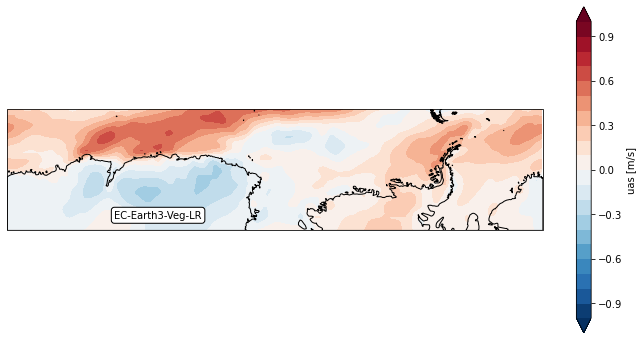

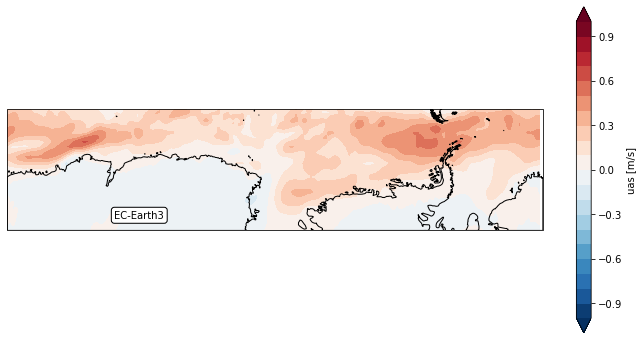

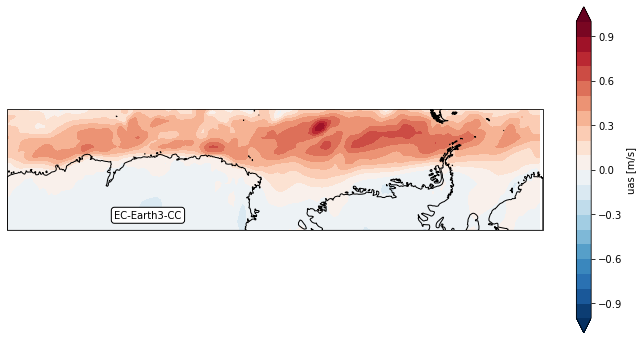

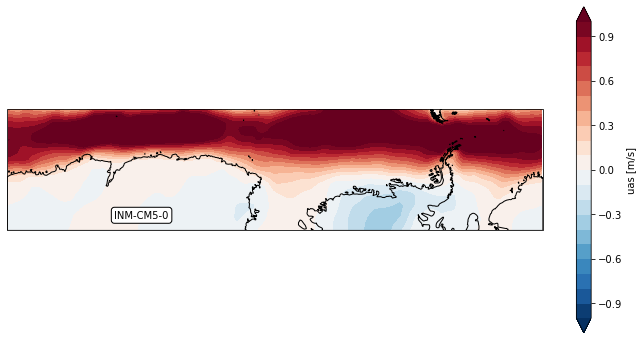

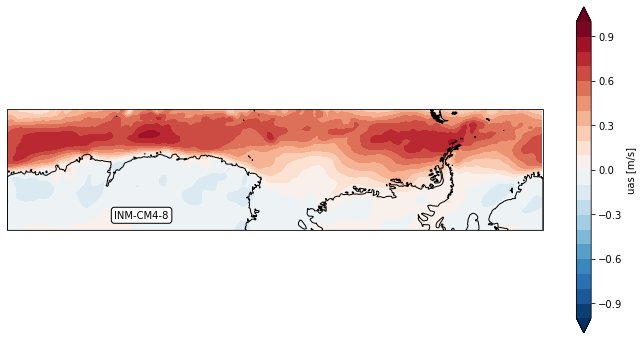

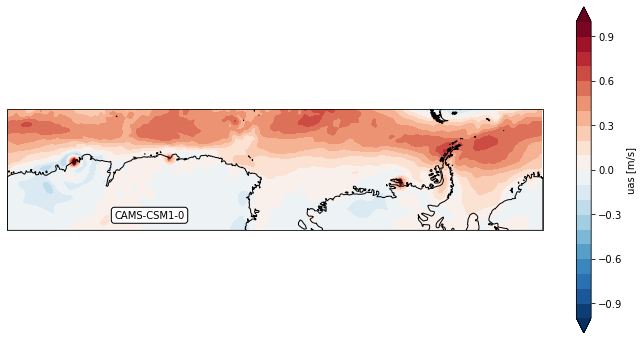

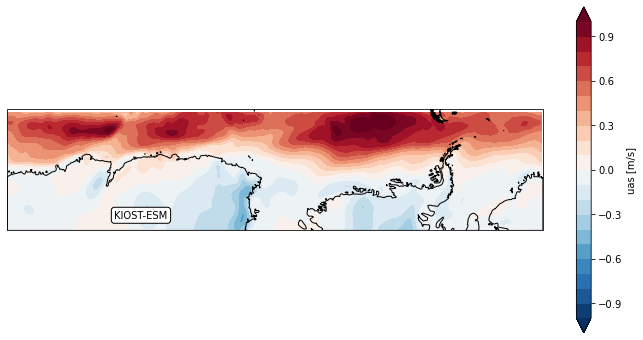

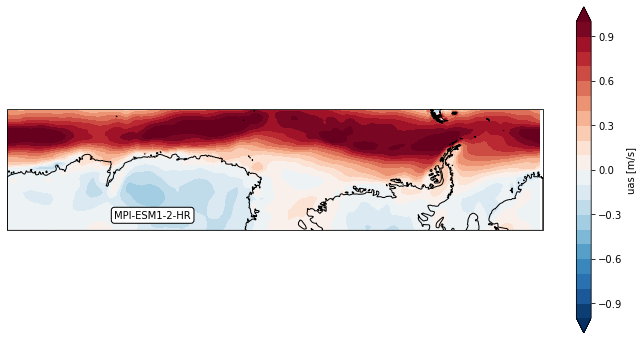

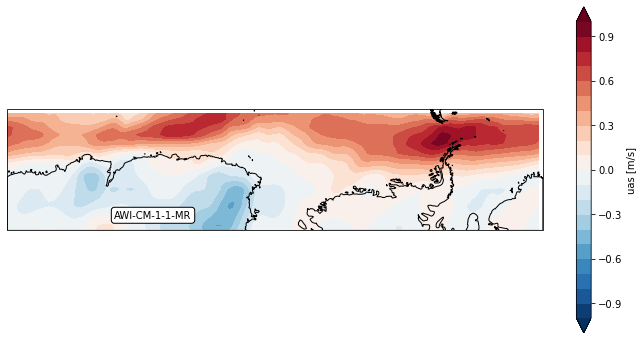

In [28]:
for i in range(0, len(uas_ssp45['model'])):
    uas_ssp45_historical = uas_ssp45.isel(model = i) - uas_historical.sel(model = uas_ssp45['model'].isel(model = i).item())
    fig, axs = pt.circumpolar_map()
    cf = axs.contourf(uas_ssp45['lon'], uas_ssp45['lat'], uas_ssp45_historical,
                      levels = np.arange(-1, 1.1, .1), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
    axs.text(0.2, 0.1, ssp45_dirs[i].split('/')[8], transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
    cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical', shrink = .6)
    cbar.set_label('uas [m/s]')
    plt.savefig('../../results/easterlies/ssp2-4.5/'+ssp45_dirs[i].split('/')[8]+'_uas_mean_diff_historical.png', facecolor = 'white', bbox_inches = 'tight')

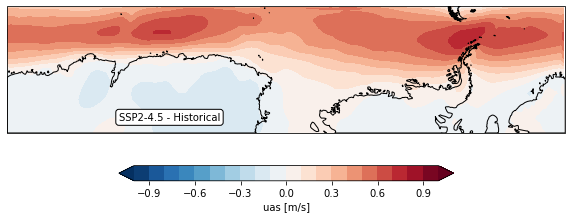

In [29]:
uas_ssp45_historical = uas_ssp45.mean('model') - uas_historical.sel(model = uas_ssp45['model']).mean('model')
fig, axs = circumpolar_map()
cf = axs.contourf(uas_jra['lon'], uas_jra['lat'], uas_ssp45_historical,
                  levels = np.arange(-1, 1.1, .1), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
axs.text(0.2, 0.1, 'SSP2-4.5 - Historical', transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
cbar = fig.colorbar(cf, ax = axs, orientation = 'horizontal', shrink = .6)
cbar.set_label('uas [m/s]')
plt.savefig('../../results/easterlies/ssp2-4.5/uas_mean_diff_historical.png', facecolor = 'white', bbox_inches = 'tight')

# SSP5-8.5

In [32]:
ssp85_dirs = glob.glob('/g/data/oi10/replicas/CMIP6/ScenarioMIP/**/**/ssp585/r1i1p1f1/Amon/uas/*/*/')
del ssp85_dirs[-1]

uas_cmip_ssp85 = {}
for file_path in ssp85_dirs:
    model_name = file_path.split('/')[8]
    uas = xr.open_mfdataset(file_path+'*.nc', parallel = True, preprocess = extract_so, decode_times = False).isel(time = slice(None, 1032))
    uas_cmip_ssp85[model_name] = uas

uas_ssp85 = uas_cmip_ssp85[ssp85_dirs[2].split('/')[8]]['uas'].interp(lat = uas_jra['lat'], lon = uas_jra['lon']).mean('time')
model_coord = [ssp85_dirs[2].split('/')[8]]
for i in range(3, len(ssp85_dirs)):
    if ssp85_dirs[i].split('/')[8] in ['CIESM', 'CMCC-CM2-SR5', 'CMCC-CM2-HR4', 'CMCC-ESM2', 'CAS-ESM2-0', 'CAMS-CSM1-0']:
        pass
    else:
        uas_ssp85 = xr.concat([uas_ssp85, uas_cmip_ssp85[ssp85_dirs[i].split('/')[8]]['uas'].interp(lat = uas_jra['lat'], lon = uas_jra['lon']).mean('time')], dim = 'model')
        model_coord.append(ssp85_dirs[i].split('/')[8])
uas_ssp85 = uas_ssp85.assign_coords({'model':model_coord})

/g/data/e14/jn8053/project-2-v0/src/easterlies/plot_tools.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (10, 4))


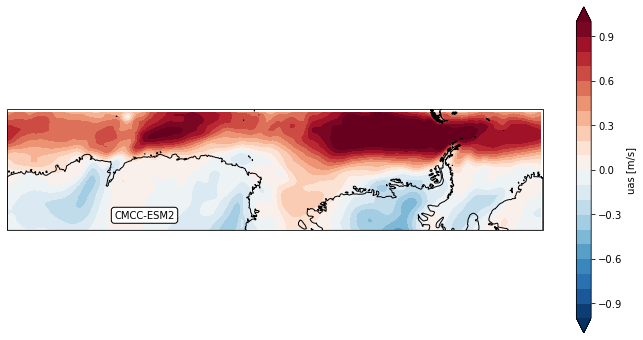

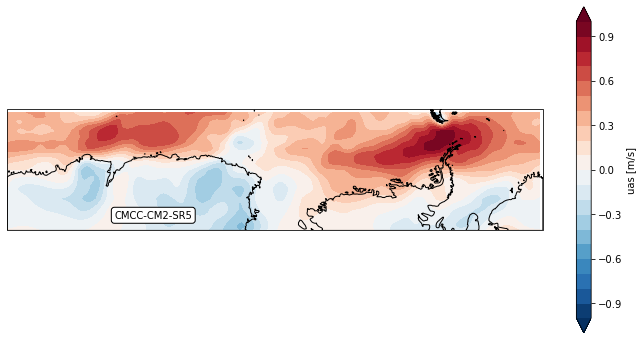

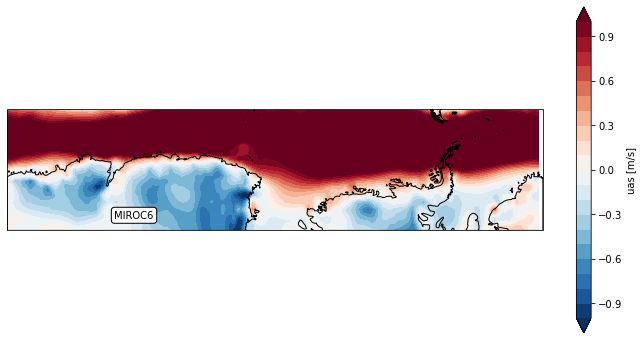

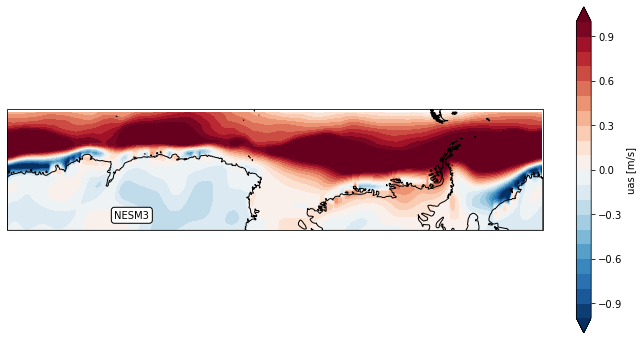

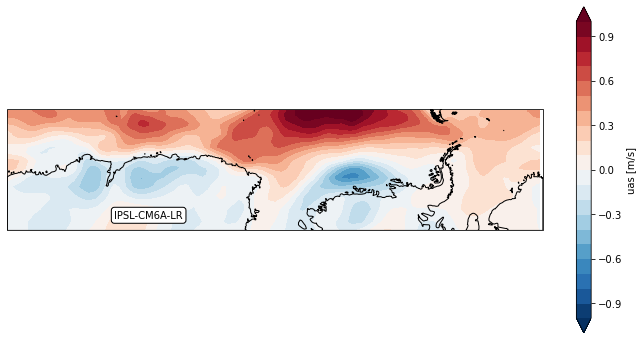

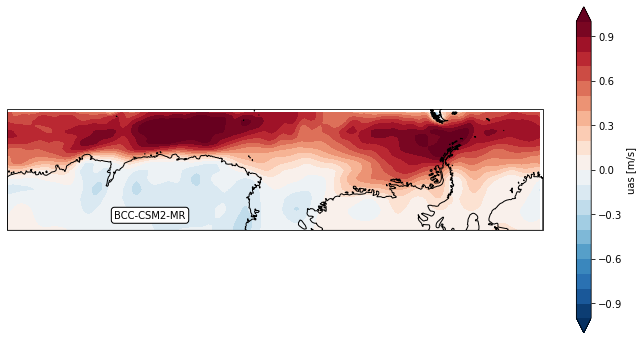

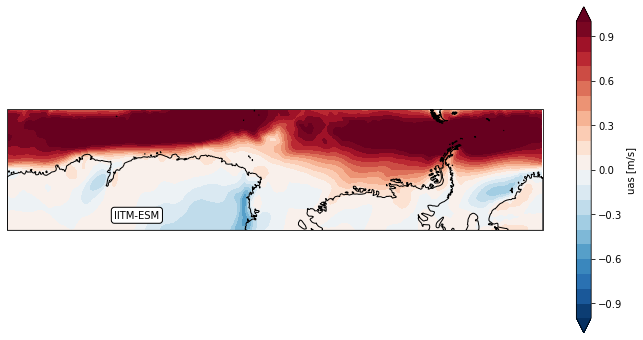

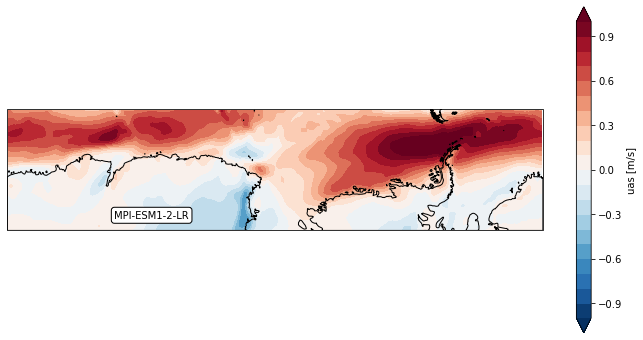

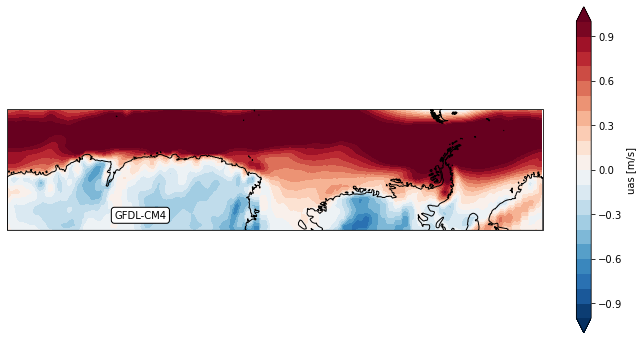

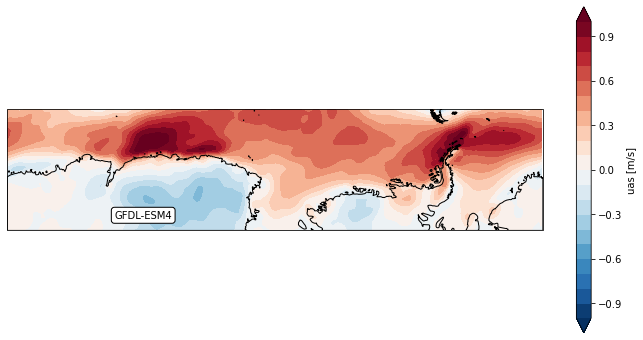

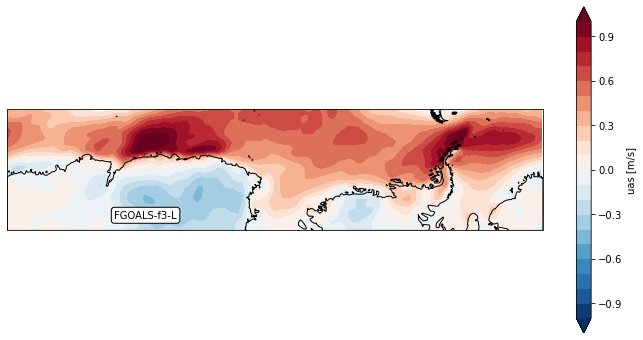

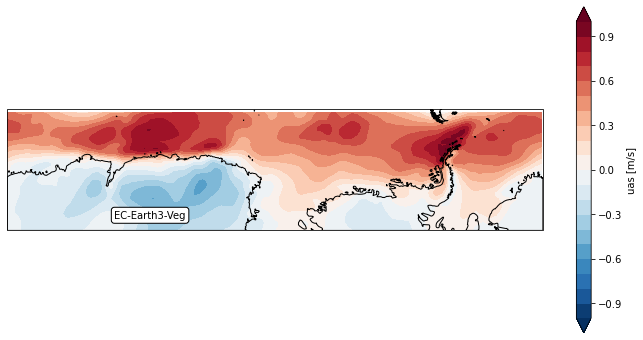

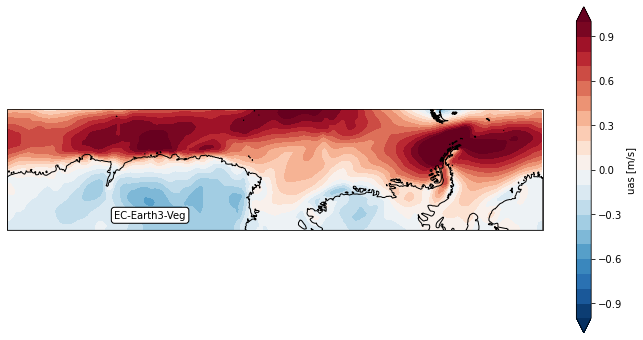

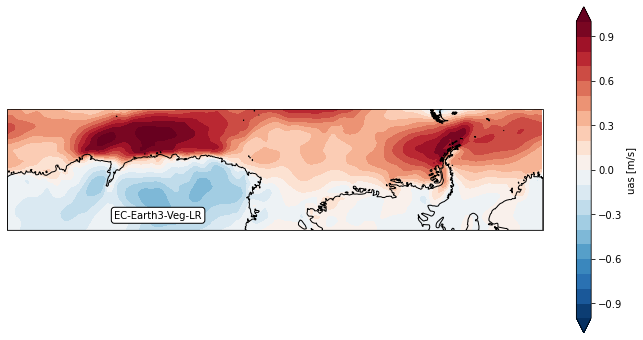

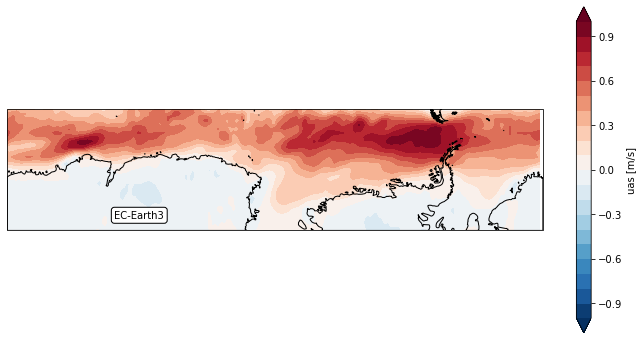

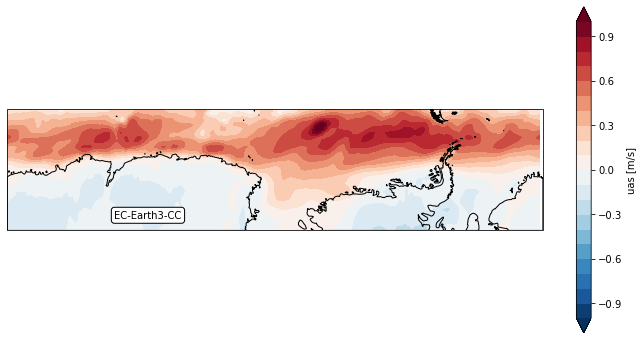

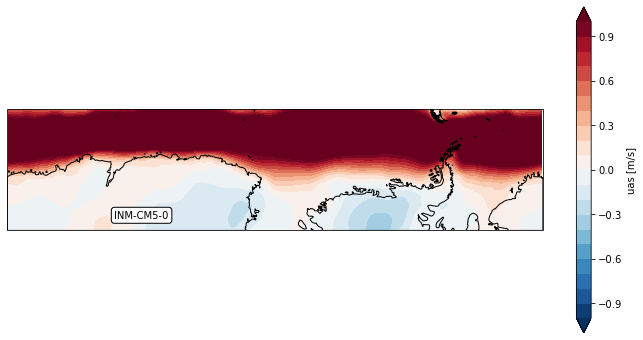

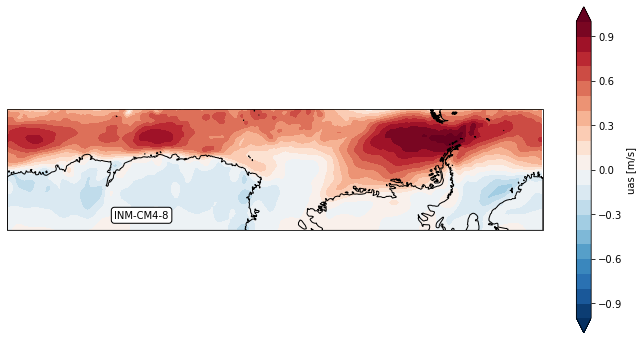

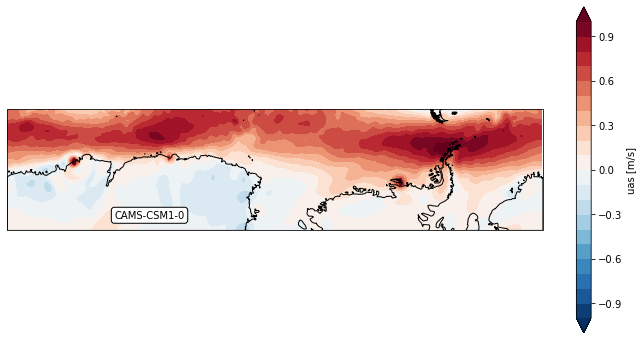

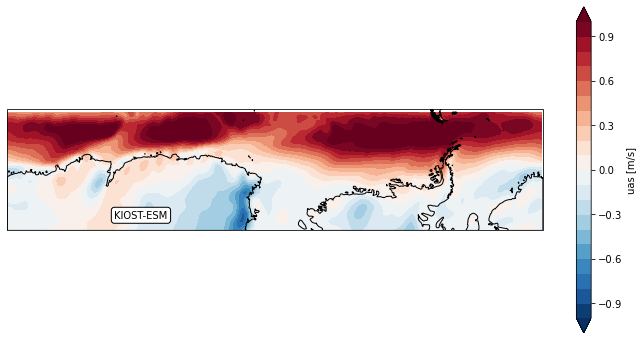

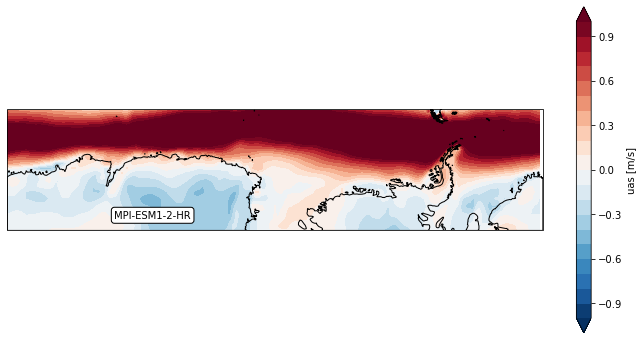

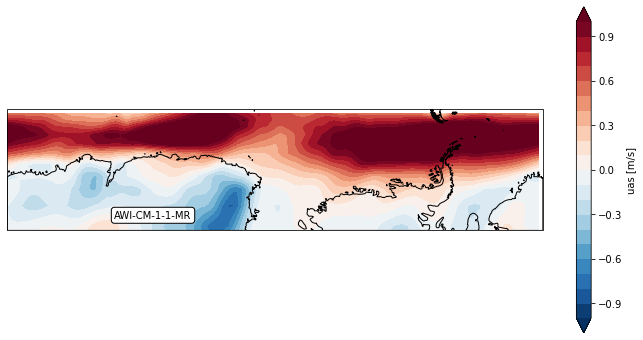

In [33]:
for i in range(0, len(uas_ssp85['model'])):
    uas_ssp85_historical = uas_ssp85.isel(model = i) - uas_historical.sel(model = uas_ssp85['model'].isel(model = i).item())
    fig, axs = pt.circumpolar_map()
    cf = axs.contourf(uas_ssp85['lon'], uas_ssp85['lat'], 
                      uas_ssp85_historical,
                      levels = np.arange(-1, 1.1, .1), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
    axs.text(0.2, 0.1, ssp85_dirs[i].split('/')[8], transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
    cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical', shrink = .6)
    cbar.set_label('uas [m/s]')
    plt.savefig('../../results/easterlies/ssp5-8.5/'+ssp85_dirs[i].split('/')[8]+'_uas_mean_diff_historical.png', facecolor = 'white', bbox_inches = 'tight')

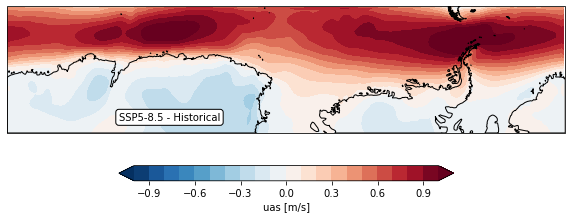

In [34]:
uas_ssp85_historical = uas_ssp85.mean('model') - uas_historical.sel(model = uas_ssp85['model']).mean('model')
fig, axs = circumpolar_map()
cf = axs.contourf(uas_jra['lon'], uas_jra['lat'], uas_ssp85_historical,
                  levels = np.arange(-1, 1.1, .1), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
axs.text(0.2, 0.1, 'SSP5-8.5 - Historical', transform = axs.transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
cbar = fig.colorbar(cf, ax = axs, orientation = 'horizontal', shrink = .6)
cbar.set_label('uas [m/s]')
plt.savefig('../../results/easterlies/ssp5-8.5/uas_mean_diff_historical.png', facecolor = 'white', bbox_inches = 'tight')

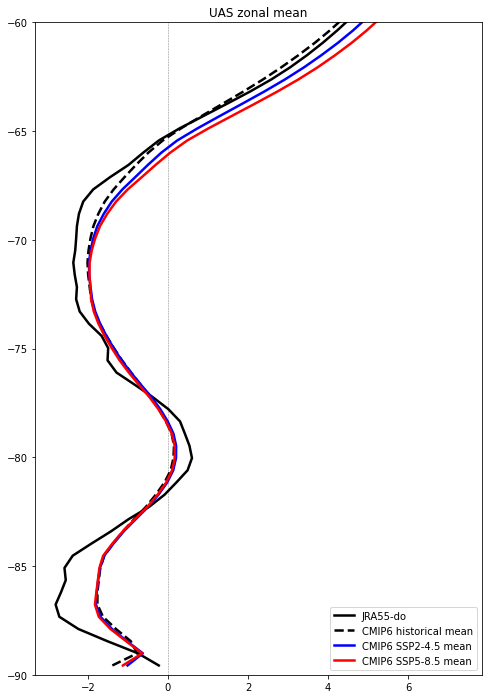

In [40]:
fig, axs = plt.subplots(figsize = (8, 12))
axs.axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
axs.set_ylim(-90, -60)
uas_jra_z = uas_jra['uas'].mean('time').mean('lon')
axs.plot(uas_jra_z, uas_jra_z['lat'], color = 'k', linewidth = 2.5, label = 'JRA55-do')
axs.plot(uas_historical.mean(['model', 'lon']), uas_historical['lat'], color = 'k', 
         linewidth = 2.5, linestyle = '--', label = 'CMIP6 historical mean')
axs.plot(uas_ssp45.mean(['model', 'lon']), uas_ssp45['lat'], color = 'b', 
         linewidth = 2.5, label = 'CMIP6 SSP2-4.5 mean')
axs.plot(uas_ssp85.mean(['model', 'lon']), uas_ssp85['lat'], color = 'r', 
         linewidth = 2.5, label = 'CMIP6 SSP5-8.5 mean')
plt.title('UAS zonal mean')
plt.legend()
plt.savefig('../../results/easterlies/uas_zonal_mean_historical_scenarios.png', facecolor = 'white', bbox_inches = 'tight')

# Along-slope wind

From https://github.com/COSIMA/cosima-recipes

Create a mask for the 1000m isobath. This is used to mask the winds later on:

In [50]:
hu = xr.open_dataset('/home/561/jn8053/g_e14/project-1-v3/data/raw_outputs/hu-01deg.nc')['hu']
dhu_dx = hu.diff('xu_ocean')
dhu_dy = hu.diff('yu_ocean')

# Select latitude slice
lat_slice = slice(-80, -59)
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

dhu_dx = change_lon_space(dhu_dx)
dhu_dy = change_lon_space(dhu_dy)
topographic_slope_magnitude = change_lon_space(topographic_slope_magnitude)

In [8]:
# Create a 1000m isobath mask
contour_file = np.load('../../data/Antarctic_slope_contour_hu_1000m.npz')
shelf_mask = contour_file['contour_mask_numbered']
xu_ocean = contour_file['xu_ocean']
yu_ocean = contour_file['yu_ocean']
shelf_mask[shelf_mask != 0] = 1
shelf_mask[shelf_mask == 0] = np.nan
shelf_mask_array = xr.DataArray(shelf_mask, dims = ['yu_ocean', 'xu_ocean'], coords = {'yu_ocean':yu_ocean, 'xu_ocean':xu_ocean})
shelf_mask_array = change_lon_space(shelf_mask_array)

shelf_mask_array.to_netcdf('../../data/Antarctic_slope_mask.nc')

## Multimodel Mean

In [56]:
U = uas_jra['uas'].mean('time')
V = vas_jra['vas'].mean('time')

u_cmip = xr.open_dataset('../../data/uas_cmip6_historical_mmm.nc')
v_cmip = xr.open_dataset('../../data/vas_cmip6_historical_mmm.nc')

U_cmip = u_cmip.mean('time')
V_cmip = v_cmip.mean('time')

In [57]:
# Along-slope velocity JRA mean
uas_int = U.interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
vas_int = V.interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
u_along = uas_int*dhu_dy/topographic_slope_magnitude - vas_int*dhu_dx/topographic_slope_magnitude

In [58]:
# Along-slope velocity CMIP mean
uas_int_cmip = U_cmip.interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
vas_int_cmip = V_cmip.interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
u_along_cmip = uas_int_cmip*dhu_dy/topographic_slope_magnitude - vas_int_cmip*dhu_dx/topographic_slope_magnitude

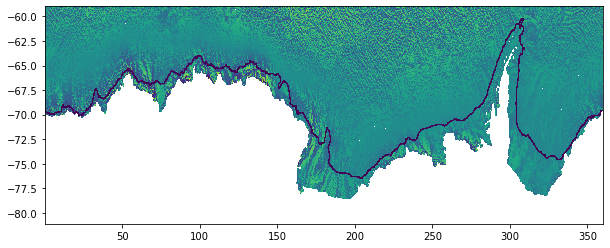

In [83]:
plt.figure(figsize=(10,4))
plt.pcolormesh(u_along['lon'], u_along['lat'], u_along, shading = 'nearest')
plt.pcolormesh(shelf_mask_array['lon'], shelf_mask_array['lat'], shelf_mask_array, shading = 'nearest')

In [23]:
ws_along_slope = u_along*shelf_mask_array

In [30]:
ws_along_slope_cmip = u_along_cmip*shelf_mask_array

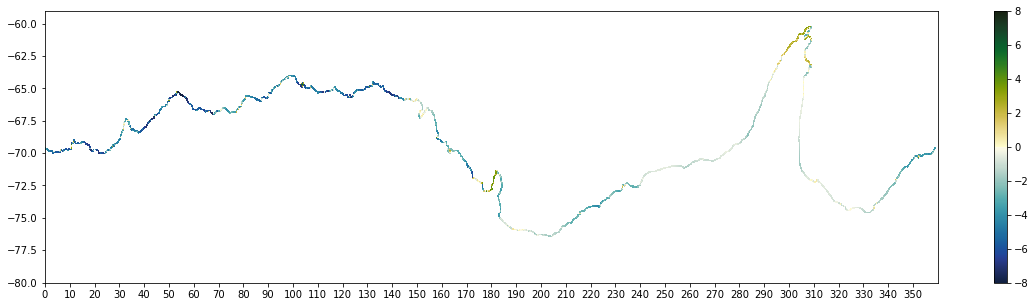

In [32]:
plt.figure(figsize=(20, 5))
plt.pcolormesh(ws_along_slope['lon'], ws_along_slope['lat'], ws_along_slope, vmin = -8, vmax = 8, cmap = cmocean.cm.delta, shading = 'nearest')
plt.xlim(0, 360);
plt.xticks(np.arange(0, 360, 10))
plt.colorbar()
plt.savefig('../../results/easterlies/historical/ws_alongslope_mean_jra55.png', facecolor = 'white', bbox_inches = 'tight')

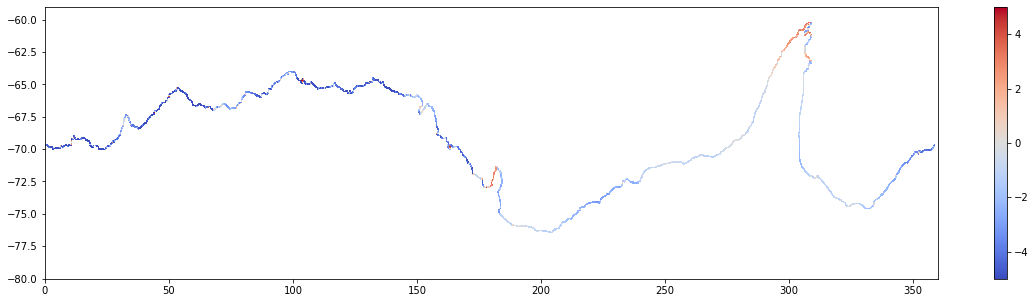

In [257]:
plt.figure(figsize=(20, 5))
plt.pcolormesh(ws_along_slope_cmip['lon'], ws_along_slope_cmip['lat'], ws_along_slope_cmip, vmin = -5, vmax = 5, cmap = 'coolwarm', shading = 'nearest')
plt.xlim(0, 360);
plt.colorbar()
plt.savefig('../../results/easterlies/historical/ws_alongslope_mean_cmip6.png', facecolor = 'white', bbox_inches = 'tight')

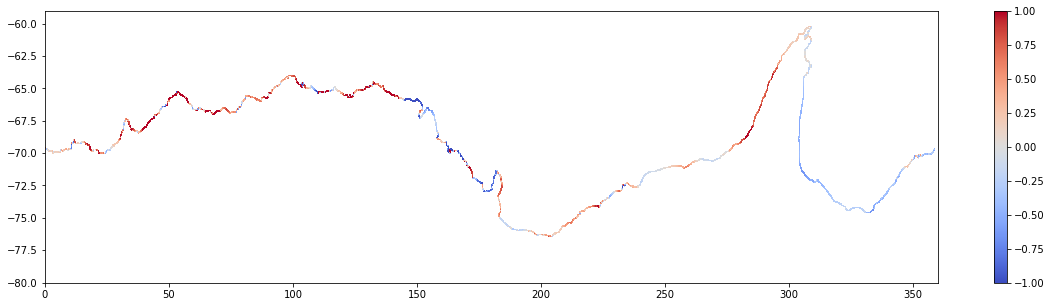

In [258]:
plt.figure(figsize=(20, 5))
plt.pcolormesh(ws_along_slope_cmip['lon'], ws_along_slope_cmip['lat'], ws_along_slope_cmip-ws_along_slope, vmin = -1, vmax = 1, cmap = 'coolwarm', shading = 'nearest')
plt.xlim(0, 360);
plt.colorbar()
plt.savefig('../../results/easterlies/historical/ws_alongslope_mean_cmip6-jra55.png', facecolor = 'white', bbox_inches = 'tight')

## Seasonal

In [51]:
# Along-slope velocity JRA 
u = uas_jra['uas'].groupby('time.month').mean('time').interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
v = uas_jra['uas'].groupby('time.month').mean('time').interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
u_along_jra = u*dhu_dy/topographic_slope_magnitude - v*dhu_dx/topographic_slope_magnitude
u_along_jra = u_along_jra*shelf_mask_array

In [54]:
# Along-slope velocity CMIP mean
u = xr.open_dataset('../../data/uas_cmip6_historical_mmm.nc')
v = xr.open_dataset('../../data/vas_cmip6_historical_mmm.nc')
u = u['uas'].groupby('time.month').mean('time').interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
v = v['vas'].groupby('time.month').mean('time').interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
u_along_cmip_mmm = u*dhu_dy/topographic_slope_magnitude - v*dhu_dx/topographic_slope_magnitude
u_along_cmip_mmm = u_along_cmip_mmm*shelf_mask_array

In [52]:
u_files = np.sort(glob.glob('../../data/cmip6-models/uas*.nc'))
v_files = np.sort(glob.glob('../../data/cmip6-models/vas*.nc'))

In [53]:
u_along_cmip = {}
for i in range(len(u_files)):
    u = xr.open_dataset(u_files[i]).groupby('time.month').mean('time')
    v = xr.open_dataset(v_files[i]).groupby('time.month').mean('time')
    u = u['uas'].interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
    v = v['vas'].interp(lon = dhu_dy['lon'], lat = dhu_dy['lat'])
    u_along_cmip[u_files[i][32:-3]] = u*dhu_dy/topographic_slope_magnitude - v*dhu_dx/topographic_slope_magnitude
    u_along_cmip[u_files[i][32:-3]] = u_along_cmip[u_files[i][32:-3]]*shelf_mask_array

Weddell Sea region:

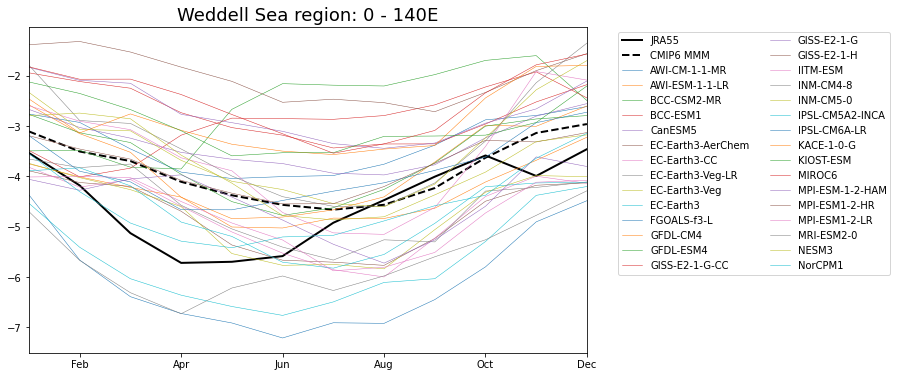

In [126]:
plt.figure(figsize = (10, 6))
plt.plot(u_along_jra.sel(lon = slice(0, 140)).mean(['lat', 'lon']), color = 'k', linewidth = 2, label = 'JRA55')
plt.plot(u_along_cmip_mmm.sel(lon = slice(0, 140)).mean(['lat', 'lon']), color = 'k', linewidth = 2, linestyle = '--', label = 'CMIP6 MMM')
for i in range(len(u_files)):
    plt.plot(u_along_cmip[u_files[i][32:-3]].sel(lon = slice(0, 140)).mean(['lat', 'lon']), 
             linewidth = 0.5, label = u_files[i][32:-3])
plt.xlim(0, 11)
plt.xticks(np.arange(1, 13, 2), ['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec']);
plt.title('Weddell Sea region: 0 - 140E', fontsize = 18);
plt.legend(ncol = 2, bbox_to_anchor = (1.3, 1), loc = 'upper center')
plt.savefig('../../results/easterlies/historical/u_along-historical-climatology-ws.png', facecolor = 'white', bbox_inches = 'tight')

Ross Sea west region:

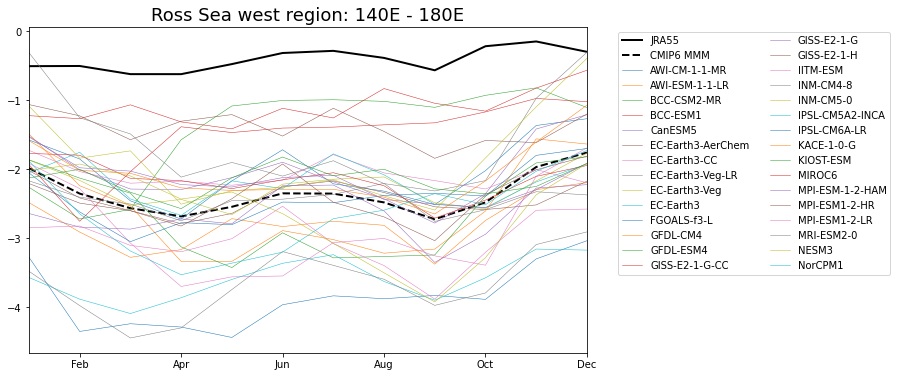

In [127]:
plt.figure(figsize = (10, 6))
plt.plot(u_along_jra.sel(lon = slice(140, 180)).mean(['lat', 'lon']), color = 'k', linewidth = 2, label = 'JRA55')
plt.plot(u_along_cmip_mmm.sel(lon = slice(140, 180)).mean(['lat', 'lon']), color = 'k', linewidth = 2, linestyle = '--', label = 'CMIP6 MMM')
for i in range(len(u_files)):
    plt.plot(u_along_cmip[u_files[i][32:-3]].sel(lon = slice(140, 180)).mean(['lat', 'lon']), 
             linewidth = 0.5, label = u_files[i][32:-3])
plt.xlim(0, 11)
plt.xticks(np.arange(1, 13, 2), ['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec']);
plt.title('Ross Sea west region: 140E - 180E', fontsize = 18);
plt.legend(ncol = 2, bbox_to_anchor = (1.3, 1), loc = 'upper center')
plt.savefig('../../results/easterlies/historical/u_along-historical-climatology-rw.png', facecolor = 'white', bbox_inches = 'tight')

Ross Sea east region:

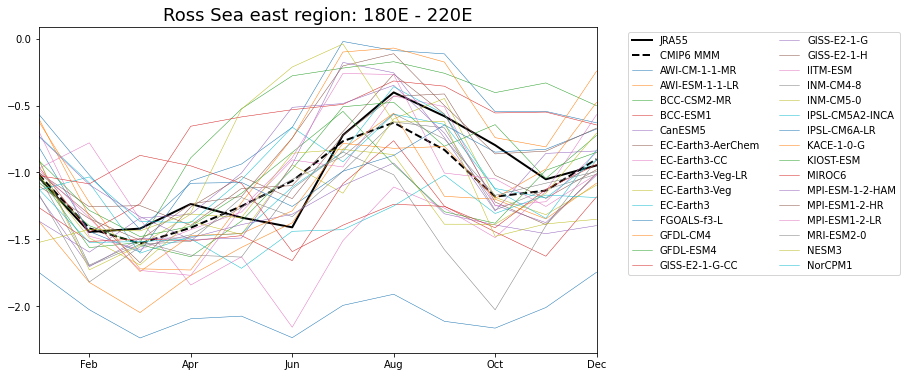

In [128]:
plt.figure(figsize = (10, 6))
plt.plot(u_along_jra.sel(lon = slice(180, 220)).mean(['lat', 'lon']), color = 'k', linewidth = 2, label = 'JRA55')
plt.plot(u_along_cmip_mmm.sel(lon = slice(180, 220)).mean(['lat', 'lon']), color = 'k', linewidth = 2, linestyle = '--', label = 'CMIP6 MMM')
for i in range(len(u_files)):
    plt.plot(u_along_cmip[u_files[i][32:-3]].sel(lon = slice(180, 220)).mean(['lat', 'lon']), 
             linewidth = 0.5, label = u_files[i][32:-3])
plt.xlim(0, 11)
plt.xticks(np.arange(1, 13, 2), ['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec']);
plt.title('Ross Sea east region: 180E - 220E', fontsize = 18);
plt.legend(ncol = 2, bbox_to_anchor = (1.3, 1), loc = 'upper center')
plt.savefig('../../results/easterlies/historical/u_along-historical-climatology-re.png', facecolor = 'white', bbox_inches = 'tight')

AB region:

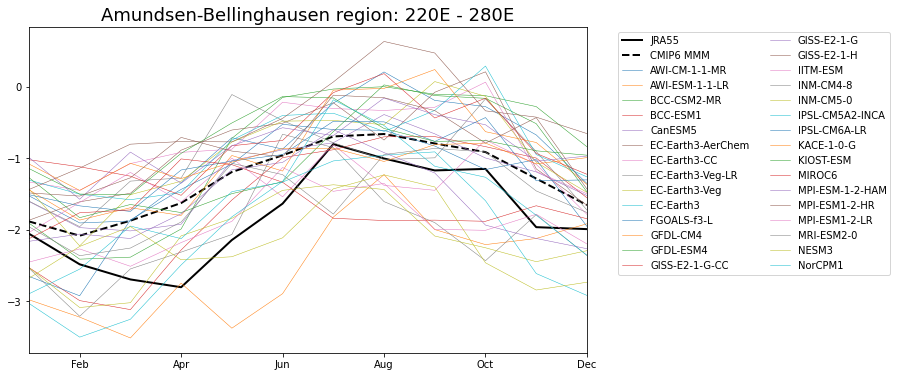

In [129]:
plt.figure(figsize = (10, 6))
plt.plot(u_along_jra.sel(lon = slice(220, 280)).mean(['lat', 'lon']), color = 'k', linewidth = 2, label = 'JRA55')
plt.plot(u_along_cmip_mmm.sel(lon = slice(220, 280)).mean(['lat', 'lon']), color = 'k', linewidth = 2, linestyle = '--', label = 'CMIP6 MMM')
for i in range(len(u_files)):
    plt.plot(u_along_cmip[u_files[i][32:-3]].sel(lon = slice(220, 280)).mean(['lat', 'lon']), 
             linewidth = 0.5, label = u_files[i][32:-3])
plt.xlim(0, 11)
plt.xticks(np.arange(1, 13, 2), ['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec']);
plt.title('Amundsen-Bellinghausen region: 220E - 280E', fontsize = 18);
plt.legend(ncol = 2, bbox_to_anchor = (1.3, 1), loc = 'upper center')
plt.savefig('../../results/easterlies/historical/u_along-historical-climatology-ab.png', facecolor = 'white', bbox_inches = 'tight')

Antarctic Peninsula region:

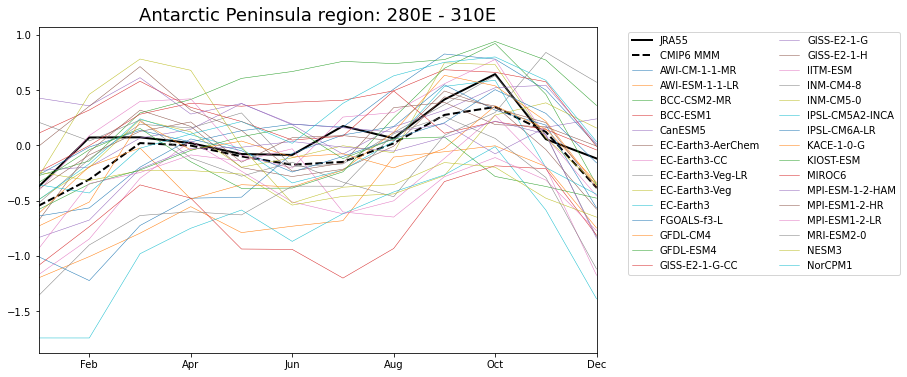

In [130]:
plt.figure(figsize = (10, 6))
plt.plot(u_along_jra.sel(lon = slice(280, 310)).mean(['lat', 'lon']), color = 'k', linewidth = 2, label = 'JRA55')
plt.plot(u_along_cmip_mmm.sel(lon = slice(280, 310)).mean(['lat', 'lon']), color = 'k', linewidth = 2, linestyle = '--', label = 'CMIP6 MMM')
for i in range(len(u_files)):
    plt.plot(u_along_cmip[u_files[i][32:-3]].sel(lon = slice(280, 310)).mean(['lat', 'lon']), 
             linewidth = 0.5, label = u_files[i][32:-3])
plt.xlim(0, 11)
plt.xticks(np.arange(1, 13, 2), ['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec']);
plt.title('Antarctic Peninsula region: 280E - 310E', fontsize = 18);
plt.legend(ncol = 2, bbox_to_anchor = (1.3, 1), loc = 'upper center')
plt.savefig('../../results/easterlies/historical/u_along-historical-climatology-ap.png', facecolor = 'white', bbox_inches = 'tight')

Filchner region:

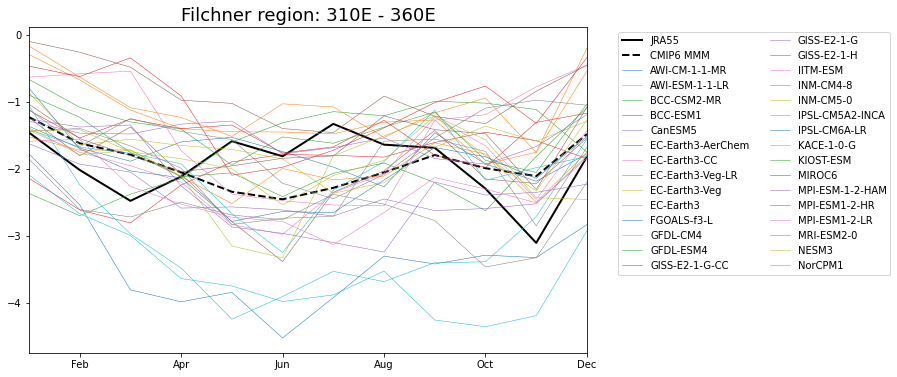

In [131]:
plt.figure(figsize = (10, 6))
plt.plot(u_along_jra.sel(lon = slice(310, None)).mean(['lat', 'lon']), color = 'k', linewidth = 2, label = 'JRA55')
plt.plot(u_along_cmip_mmm.sel(lon = slice(310, None)).mean(['lat', 'lon']), color = 'k', linewidth = 2, linestyle = '--', label = 'CMIP6 MMM')
for i in range(len(u_files)):
    plt.plot(u_along_cmip[u_files[i][32:-3]].sel(lon = slice(310, None)).mean(['lat', 'lon']), 
             linewidth = 0.5, label = u_files[i][32:-3])
plt.xlim(0, 11)
plt.xticks(np.arange(1, 13, 2), ['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec']);
plt.title('Filchner region: 310E - 360E', fontsize = 18);
plt.legend(ncol = 2, bbox_to_anchor = (1.3, 1), loc = 'upper center')
plt.savefig('../../results/easterlies/historical/u_along-historical-climatology-fr.png', facecolor = 'white', bbox_inches = 'tight')

# Shelf wind

In [72]:
contour_file = np.load('/g/data/e14/hd4873/runs/parcels/input/proj01/Antarctic_slope_contour_ht_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
xu_ocean = contour_file['xt_ocean']
yu_ocean = contour_file['yt_ocean']
shelf_mask_array = xr.DataArray(shelf_mask, dims = ['yu_ocean', 'xu_ocean'], 
                                coords = {'xu_ocean':xu_ocean, 'yu_ocean':yu_ocean})
shelf_mask_array = change_lon_space(shelf_mask_array)

hu = xr.open_dataset('/home/561/jn8053/g_e14/project-1-v3/data/raw_outputs/hu-01deg.nc')['hu']
hu = change_lon_space(hu)
hu = hu.interp(lat = shelf_mask_array['lat'], lon = shelf_mask_array['lon'])

In [81]:
shelf_mask_array = shelf_mask_array.where(shelf_mask_array>=0)
shelf_mask_array = shelf_mask_array.where(~np.isnan(hu))
shelf_mask_array = shelf_mask_array.where(np.isnan(shelf_mask_array), 1)

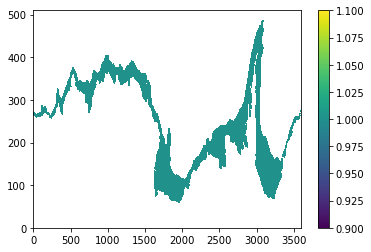

In [93]:
plt.pcolormesh(shelf_mask_array, shading = 'auto')
plt.colorbar()

In [99]:
u_jra_shelf = shelf_mask_array.interp(lon = u_along['lon'], lat = u_along['lat'])*u_along
u_cmip_shelf = shelf_mask_array.interp(lon = u_along['lon'], lat = u_along['lat'])*u_along_cmip

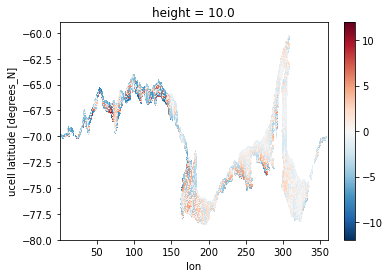

In [100]:
u_jra_shelf.plot()